In [1]:
import yahoo_fin.stock_info as si
import pandas as pd
import numpy as np
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm

list_banks = ['ZION','SBNY','NYCB','WAL','BKU','CMA','EWBC','BAC','C','AXP','COF']

def get_price_data(ticker):
    price_data = si.get_data(ticker,start_date = '01/01/2009')
    df = pd.DataFrame(price_data)
    df = df[['adjclose']]
    df['pct_change'] = df.adjclose.pct_change()
    df['log_return'] = np.log(1 + df['pct_change'].astype(float))
    df['ticker'] = ticker
    return df

def get_portfolio_return(df,list_stocks,n):
    df = df.iloc[-n:,].copy()
    for col in df.columns:
        if col in list_stocks:
            df[col+'_cmltv_ret'] = np.exp(np.log1p(df[col]).cumsum())-1
    list_cols = []
    for col in df.columns:
        if 'cmltv' in col and 'SPY' not in col:
            list_cols.append(col)
    df['portfolio_return'] = df[list_cols].mean(axis=1)
    return df

def get_betas(x,y,n=0):
    if n > 0:
        x = x.iloc[-n:,]
        y = y.iloc[-n:,]
    res = sm.OLS(y, x).fit()
    ticker = col.split('_')[0]
    beta = res.params[0]
    r2 = res.rsquared
    n = len(x)
    return [beta,r2,n]

list_df = []
for item in list_banks:
    df = get_price_data(item)
    list_df.append(df)



In [2]:
df_long = pd.concat(list_df,axis = 0).reset_index()
df_wide = df_long.pivot_table(index=["index"],
                    columns='ticker',
                    values='pct_change')

spy = get_price_data('TLT').reset_index()

dataset = pd.merge(spy,df_wide,how = 'inner',left_on='index',right_on='index')

betas = {}
ns = {}
r2s = {}
for col in dataset.columns:
    if col in list_banks:
        df = dataset[['pct_change',col]].dropna()
        beta,r2,n = get_betas(df['pct_change'],df[col])
        betas[col]=beta
        ns[col]=n
        r2s[col]=r2

PRINT LIST OF BETAS VS the TLT... INVERSE BETAS = GREATER ASSET SENSITIVITY
LIST SORTED FROM MOST ASSET SENSITIVE TO LEAST

In [3]:
 {k: v for k, v in sorted(betas.items(), key=lambda item: item[1])}

{'BAC': -1.2099177153347869,
 'ZION': -1.1745198471728282,
 'C': -1.1615877005615018,
 'EWBC': -1.1372353323429443,
 'WAL': -1.135667705719342,
 'CMA': -1.1078751517170213,
 'COF': -0.9205632427024835,
 'SBNY': -0.8309165667649835,
 'BKU': -0.7776116852163925,
 'AXP': -0.7331478001343814,
 'NYCB': -0.6640720903170299}

In [4]:
ns

{'AXP': 3026,
 'BAC': 3026,
 'BKU': 2504,
 'C': 3026,
 'CMA': 3026,
 'COF': 3026,
 'EWBC': 3026,
 'NYCB': 3026,
 'SBNY': 3026,
 'WAL': 3026,
 'ZION': 3026}

In [5]:
dataset_stocks = dataset.drop(columns = ['adjclose','pct_change','log_return','ticker'])
portfolio_return = get_portfolio_return(dataset_stocks,list_banks,n=252)
spy_return = get_portfolio_return(dataset[['pct_change']],'pct_change',n=252)
spy_return = spy_return.drop(columns = ['pct_change','pct_change_cmltv_ret'])
spy_return.columns = ['SPY_return']

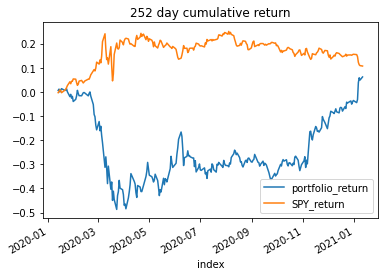

In [6]:
df_plot = pd.concat([portfolio_return,spy_return],axis = 1)
df_plot.set_index('index')[['portfolio_return','SPY_return']].plot(title = '252 day cumulative return')